# General

In [1]:
from os import listdir
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

In [2]:
sns.set_context('talk')

In [3]:
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

# Quantifying enrichment of actin at dumbbell GUV necks

In [4]:
cd O:\TUD\__eDICE-paper\__for-paper\data_publication\actin-enrichment_dumbbells

O:\TUD\__eDICE-paper\__for-paper\data_publication\actin-enrichment_dumbbells


### Load full profiles across membrane (along symmetry axis and across neck)

Locate data

In [5]:
thefilepath = r'O:\TUD\__eDICE-paper\__for-paper\data_publication\actin-enrichment_dumbbells'

files_csv = find_csv_filenames( thefilepath )
files_tif = find_csv_filenames( thefilepath, suffix='.tif' )

Load data along symmetry axis of each GUV

In [6]:
# initialize dataframe
df_symm = pd.DataFrame()

# iterate over GUVs
for file in files_tif:
    
    basename = file.split('.tif')[0]
    
    df_temp = pd.DataFrame(columns=['distance (um)', 
                                    'actin intensity', 'membrane intensity', 
                                    'image'])
    # load profiles
    df_actin_temp = pd.read_csv(basename+'__actin_profile-axis.csv', skiprows=[0],
                                names=['distance (um)', 'grey actin'])
    df_membrane_temp = pd.read_csv(basename+'__membrane_profile-axis.csv', skiprows=[0],
                                names=['distance (um)', 'grey membrane'])

    df_temp['distance (um)']=df_actin_temp['distance (um)']
    df_temp['actin intensity']=df_actin_temp['grey actin']
    df_temp['membrane intensity']=df_membrane_temp['grey membrane']
    df_temp['image']=len(df_temp)*[basename]
    
    # associate microscope on which data was acquired
    if int(file[0:8]) < 20220101:
        df_temp['microscope']='BN SD'
    else:
        df_temp['microscope']='Stellaris'


    # write into one common dataframe
    df_symm = pd.concat([df_symm, df_temp])

# display first lines of the dataframe    
df_symm.head(3)

,distance (um),actin intensity,membrane intensity,image,microscope
0,0.0000,0.0,0.0499,20220114_run1_ArpB5L-5uMVCA-8uMactin_R4-1,Stellaris
1,0.3593,0.0,0.1505,20220114_run1_ArpB5L-5uMVCA-8uMactin_R4-1,Stellaris
2,0.7187,0.0,0.1895,20220114_run1_ArpB5L-5uMVCA-8uMactin_R4-1,Stellaris


Load data along through neck of each GUV

In [7]:
# initialize dataframe
df_neck = pd.DataFrame()

# iterate over GUVs
for file in files_tif:
    
    basename = file.split('.tif')[0]
    
    df_temp = pd.DataFrame(columns=['distance (um)', 
                                    'actin intensity', 'membrane intensity', 
                                    'image'])

    # load profiles    
    df_actin_temp = pd.read_csv(basename+'__actin_profile-neck.csv', skiprows=[0],
                                names=['distance (um)', 'grey actin'])
    df_membrane_temp = pd.read_csv(basename+'__membrane_profile-neck.csv', skiprows=[0],
                                names=['distance (um)', 'grey membrane'])

    df_temp['distance (um)']=df_actin_temp['distance (um)']
    df_temp['actin intensity']=df_actin_temp['grey actin']
    df_temp['membrane intensity']=df_membrane_temp['grey membrane']
    df_temp['image']=len(df_temp)*[basename]


    # write into one common dataframe
    df_neck = pd.concat([df_neck, df_temp])

    
df_neck.head(3)

,distance (um),actin intensity,membrane intensity,image
0,0.0000,0.0,0.2843,20220114_run1_ArpB5L-5uMVCA-8uMactin_R4-1
1,0.3593,0.0,0.1985,20220114_run1_ArpB5L-5uMVCA-8uMactin_R4-1
2,0.7187,0.0,0.0000,20220114_run1_ArpB5L-5uMVCA-8uMactin_R4-1


In [8]:
# clean up data (remove duplicate indices)
df_symm.reset_index(inplace=True, drop=True)
df_neck.reset_index(inplace=True, drop=True)

### Quantifying enrichment: cross line profiles

Find maximum actin intensity along symmetry axis and across neck

In [9]:
# find maxima
df_cross_symm_max = df_symm.loc[df_symm.groupby('image')['actin intensity'].idxmax()]
df_cross_neck_max = df_neck.loc[df_neck.groupby('image')['actin intensity'].idxmax()]
# find minima = background
df_cross_symm_min = df_symm.loc[df_symm.groupby('image')['actin intensity'].idxmin()]
df_cross_neck_min = df_neck.loc[df_neck.groupby('image')['actin intensity'].idxmin()]
# background subtraction
df_cross_symm = pd.merge(df_cross_symm_max, df_cross_symm_min, 
                         how='outer', on=['image'], suffixes=[' max',' min'])
df_cross_symm['actin bgs'] = df_cross_symm['actin intensity max']-df_cross_symm['actin intensity min']

# merge data for neck and symmetry axis
df_cross_neck = pd.merge(df_cross_neck_max, df_cross_neck_min, 
                         how='outer', on=['image'], suffixes=[' max',' min'])
df_cross_neck['actin bgs'] = df_cross_neck['actin intensity max']-df_cross_neck['actin intensity min']
df_cross = pd.merge(df_cross_symm, df_cross_neck, how='outer', on=['image'], suffixes=[' axis',' neck'])
# calculate enrichment by dividing background subtracted maximum intensities
df_cross['enrichment']=df_cross['actin bgs neck']/df_cross['actin bgs axis']

In [10]:
# load classification of GUVs (done by hand)
df_classification = pd.read_csv('20220408_dumbbells-enrichment-classification.txt', sep='\t', decimal=",")

# associate classification and enrichment data
df_cross = pd.merge(df_classification, df_cross, how='outer', on=['image'])

# convert classification to words
df_cross.loc[df_cross['neck enrichment all round']==1, 'enrichment type'] = 'continuous'
df_cross.loc[df_cross['neck enrichment single patch']==1, 'enrichment type'] = 'single patch'
df_cross.loc[df_cross['neck enrichment multipatch']==1, 'enrichment type'] = 'multi patch'
df_cross.loc[df_cross['enrichment neck']==0, 'enrichment type'] = 'no enrichment'

## Save data

In [11]:
df_cross.to_csv('comparing-maxima-along-and-across-neck_Stellaris.csv')
df_symm.to_csv('all-dumbbell-profiles_along-symmetry-axis_Stellaris.csv')
df_neck.to_csv('all-dumbbell-profiles_across-neck_Stellaris.csv')

# Plotting

### Enrichment quantification per GUV

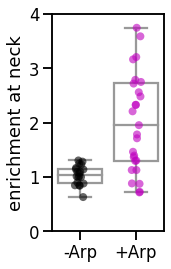

In [12]:
f = plt.figure(figsize=[2, 4])

ax = sns.stripplot(data=df_cross, y='enrichment', x='actin nucleation', palette=['k','m'], s=8, alpha=0.6)
#ax = sns.stripplot(data=df_cross.loc[df_cross['enrichment']>1], y='enrichment', x='actin nucleation',color='m', s=8, alpha=0.6)
ax = sns.boxplot(data=df_cross, y='enrichment', x='actin nucleation', color='w')

ax.set_ylabel('enrichment at neck')
ax.set_ylim(-0,4)
ax.set_xlabel('')
ax.set_xticklabels(["-Arp","+Arp"])

fig = ax.get_figure()
fig.savefig('actin-enrichment-at-neck_bgs_stellaris-dumbbells.png', dpi=300, bbox_inches='tight')

Number of data points and mean enrichment

In [13]:
print('Actin nucleating spontaneously:')
print('N =', len(df_cross.loc[df_cross['actin nucleation']==0]))
print('mean enrichment =', df_cross.loc[df_cross['actin nucleation']==0].mean()['enrichment'])

Actin nucleating spontaneously:
N = 21
mean enrichment = 1.0355222988281267


In [14]:
print('Actin nucleating on membrane:')
print('N =', len(df_cross.loc[df_cross['actin nucleation']==1]))
print('mean enrichment =', df_cross.loc[df_cross['actin nucleation']==1].mean()['enrichment'])

Actin nucleating on membrane:
N = 27
mean enrichment = 2.1532405303587785


### Enrichment as a function of VCA concentration

   VCA (uM)  enrichment neck  % of GUVs
0       2.0              1.0  87.500000
1       2.0              0.0  12.500000
2       6.5              1.0  68.421053
3       6.5              0.0  31.578947


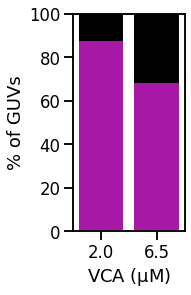

          count
VCA (uM)       
2.0           8
6.5          19


In [15]:
# filter out any data points where actin is not nucleated by Arp2/3
df_wrk = df_cross.loc[df_cross['actin nucleation']==1]

# find prevalence of CHAR under different conditions of GROUP
GROUP = 'VCA (uM)'
CHAR = 'enrichment neck'
TITLE = ''

# find prevalence of feature
df_temp = df_wrk.groupby(GROUP)[CHAR].value_counts(normalize=True)*100
df_temp = df_temp.to_frame(name='% of GUVs').reset_index()

# print these prevalences
print(df_temp)


f = plt.figure(figsize=[2, 4])

# plot data in stacked bars
total = df_temp.groupby(GROUP)['% of GUVs'].sum().reset_index()
bar1 = sns.barplot(x=GROUP,  y="% of GUVs", data=total, color='k')
bar2 = sns.barplot(x=GROUP,  y="% of GUVs", data=df_temp.loc[df_temp[CHAR]==1], color='m')

# define labels
bar1.set_title(TITLE)
bar1.set_ylim([0,100])
bar1.set_xlabel('VCA ($\mathregular{\mu M}$)')

plt.show()

# save figure
fig=bar1.get_figure()
fig.savefig('if_' + GROUP + '_then_' + CHAR +'.png', dpi=300, bbox_inches='tight')

# save sample sizes for each group
nobs = df_wrk.groupby([GROUP])[CHAR].agg(['count'])
nobs.to_csv('if_' + GROUP + '_then_' + CHAR + '_nobs.csv')

# print sample sizes
print(nobs)

   cortex  enrichment neck  % of GUVs
0     0.0              1.0  75.000000
1     0.0              0.0  25.000000
2     1.0              1.0  73.913043
3     1.0              0.0  26.086957


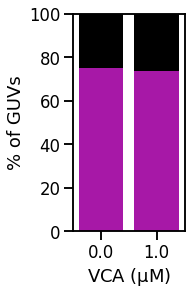

        count
cortex       
0.0         4
1.0        23


In [16]:
# filter out any data points where actin is not nucleated by Arp2/3
df_wrk = df_cross.loc[df_cross['actin nucleation']==1]

# find prevalence of CHAR under different conditions of GROUP
GROUP = 'cortex'
CHAR = 'enrichment neck'
TITLE = ''

# find prevalence of feature
df_temp = df_wrk.groupby(GROUP)[CHAR].value_counts(normalize=True)*100
df_temp = df_temp.to_frame(name='% of GUVs').reset_index()

# print these prevalences
print(df_temp)


f = plt.figure(figsize=[2, 4])

# plot data in stacked bars
total = df_temp.groupby(GROUP)['% of GUVs'].sum().reset_index()
bar1 = sns.barplot(x=GROUP,  y="% of GUVs", data=total, color='k')
bar2 = sns.barplot(x=GROUP,  y="% of GUVs", data=df_temp.loc[df_temp[CHAR]==1], color='m')

# define labels
bar1.set_title(TITLE)
bar1.set_ylim([0,100])
bar1.set_xlabel('VCA ($\mathregular{\mu M}$)')

plt.show()

# save figure
fig=bar1.get_figure()
fig.savefig('if_' + GROUP + '_then_' + CHAR +'.png', dpi=300, bbox_inches='tight')

# save sample sizes for each group
nobs = df_wrk.groupby([GROUP])[CHAR].agg(['count'])
nobs.to_csv('if_' + GROUP + '_then_' + CHAR + '_nobs.csv')

# print sample sizes
print(nobs)

  Arp type  enrichment neck  % of GUVs
0       A5              1.0  66.666667
1       A5              0.0  33.333333
2      B5L              1.0  70.588235
3      B5L              0.0  29.411765
4    brain              1.0  85.714286
5    brain              0.0  14.285714


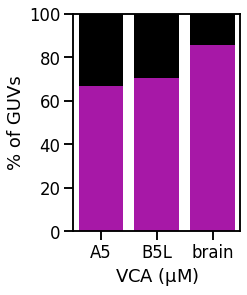

          count
Arp type       
A5            3
B5L          17
brain         7


In [17]:
# filter out any data points where actin is not nucleated by Arp2/3
df_wrk = df_cross.loc[df_cross['actin nucleation']==1]

# find prevalence of CHAR under different conditions of GROUP
GROUP = 'Arp type'
CHAR = 'enrichment neck'
TITLE = ''

# find prevalence of feature
df_temp = df_wrk.groupby(GROUP)[CHAR].value_counts(normalize=True)*100
df_temp = df_temp.to_frame(name='% of GUVs').reset_index()

# print these prevalences
print(df_temp)


f = plt.figure(figsize=[3, 4])

# plot data in stacked bars
total = df_temp.groupby(GROUP)['% of GUVs'].sum().reset_index()
bar1 = sns.barplot(x=GROUP,  y="% of GUVs", data=total, color='k')
bar2 = sns.barplot(x=GROUP,  y="% of GUVs", data=df_temp.loc[df_temp[CHAR]==1], color='m')

# define labels
bar1.set_title(TITLE)
bar1.set_ylim([0,100])
bar1.set_xlabel('VCA ($\mathregular{\mu M}$)')

plt.show()

# save figure
fig=bar1.get_figure()
fig.savefig('if_' + GROUP + '_then_' + CHAR +'.png', dpi=300, bbox_inches='tight')

# save sample sizes for each group
nobs = df_wrk.groupby([GROUP])[CHAR].agg(['count'])
nobs.to_csv('if_' + GROUP + '_then_' + CHAR + '_nobs.csv')

# print sample sizes
print(nobs)

   actin (uM) enrichment type  % of GUVs
0         8.0   no enrichment  26.923077
1         8.0    single patch  26.923077
2         8.0      continuous  23.076923
3         8.0     multi patch  23.076923
            count
actin (uM)       
8.0            26


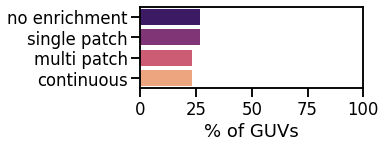

In [18]:
# filter out any data points where actin is not nucleated by Arp2/3
df_wrk = df_cross.loc[df_cross['actin nucleation']==1]

# find prevalence of CHAR under different conditions of GROUP
GROUP = 'actin (uM)'
CHAR = 'enrichment type'
TITLE = ''

# find prevalence of feature
df_temp = df_wrk.groupby(GROUP)[CHAR].value_counts(normalize=True)*100
df_temp = df_temp.to_frame(name='% of GUVs').reset_index()

# write out the values
print(df_temp)

# plot
f = plt.figure(figsize=[4, 1.5])
ax = sns.barplot(data=df_temp, 
                 x='% of GUVs', y='enrichment type', 
                 order=['no enrichment', 'single patch', 'multi patch', 'continuous'], 
                 palette='magma')
ax.set_xlim(0,100)
ax.set_ylabel('')

# save figure
fig=ax.get_figure()
fig.savefig('neck-enrichment-types.png', dpi=300, bbox_inches='tight')

# save sample sizes for each group
nobs = df_wrk.groupby([GROUP])[CHAR].agg(['count'])
nobs.to_csv('if_' + GROUP + '_then_' + CHAR + '_nobs.csv')

# print sample sizes
print(nobs)